In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score, KFold, StratifiedShuffleSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
import category_encoders as ce

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

from sklearn.metrics import mean_absolute_percentage_error
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import Lars
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from IPython.display import Image
import category_encoders as ce
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import mean_absolute_error, 
from sklearn.model_selection import ShuffleSplit

Наименование полей в файле: 

wagnum - номер вагона, 

prev_fr_id - идентификатор предыдущего груза, 

prev_is_load - признак гружености предыдущего рейса (1 -  груженый, 0 -  порожний), 

prev_date_depart - дата отправления предыдущего рейса, 

prev_date_arrival - дата прибытия предыдущего рейса, 

prev_snd_org_id - предыдущий грузоотправитель (идентификатор),

prev_rsv_org_id - предыдущий грузополучатель (идентификатор), 

prev_distance – расстояние, пройденное в предыдущем рейсе, 


snd_st_id - станция отправления текущего рейса, 

rsv_st_id - станция назначения текущего рейса, 

fr_id - идентификатор груза, 

is_load - признак гружености текущего рейса, 

date_depart - дата отправления текущего рейса, 

rod - РПС, 

common_ch - обобщенная характеристика, 

vidsobst - вид собственности, 

snd_org_id - грузоотправитель (идентификатор), 

rsv_org_id - грузополучатель (идентификатор), 

distance - расстояние, пройденное в текущем рейсе, 

prev_freight - наименование предыдущего груза, 

prev_fr_group - наименование предыдущей группы груза, 

freight - наименование груза, 

fr_group - наименование группы груза.

target - таргет (продолжительность между прибытием предыдущего рейса и отправлением текущего рейса). 


### Задача - предсказать время простоя вагона на станции между событиями прибытия вагона на станцию и его отбытия от станции

In [2]:
train_data = pd.read_parquet('train.parquet')
test_data = pd.read_parquet('test.parquet')
test_submit_example = pd.read_csv('test_submit_example.csv')

In [3]:
train_target = pd.read_csv('train_target.csv')

print("{0} неправильных значений target:".format(len(train_target[train_target['target']<0])))
display(train_target[train_target['target']<0].reset_index(drop = True))

196 неправильных значений target:


,target
0,-4.0
1,-131.0
2,-1.0
3,-90.0
4,-10.0
...,...
191,-2.0
192,-65.0
193,-8.0
194,-10.0


In [4]:
train_data = pd.read_parquet('train.parquet')
train_target = pd.read_csv('train_target.csv')
#test_submit_example = pd.read_csv('test_submit_example.csv')
# принимает весь массив
# def get_day_type(day):
# #     print(day.lower())
#     weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
#     if day in weekdays:
#     #np.array(weekdays).isin(day.lower()):
#         return 0
#     elif day in ['Saturday','Sunday']:
#         return 1
#     else:
#         return None
def prev_dest_nan_filler(train_data):
    # 1. Найдем поезда с пропущенным значением prev_distance
    one_tmp = train_data[train_data['prev_distance'].isna()][['prev_distance', 'rsv_st_id']]
    # 2. найдем все поезда, у которых та же rsv_st_id и заполнено prev_distance
    all_tmp = train_data[(train_data['rsv_st_id'].isin(one_tmp['rsv_st_id']) == True)&(train_data['prev_distance'].isna() == False )]
    # 3. сгруппируем по rsv_st_id и найдем среднее значение prev_distance
    prev_distance_mean = all_tmp.groupby('rsv_st_id')['prev_distance'].mean().reset_index()
    # 4
    replace_dict = dict(zip(prev_distance_mean['rsv_st_id'], prev_distance_mean['prev_distance']))
    #train_data.fillna({'prev_distance': replace_dict.set_index('rsv_st_id')['prev_distance']})
    train_data['prev_distance'] = train_data['prev_distance'].fillna(train_data.rsv_st_id.map(replace_dict))
    return train_data

def dist_nan_filler(dta):
    # 1. Найдем поезда с пропущенным значением distance
    one_tmp = dta[dta['distance'].isna()][['distance', 'snd_st_id']]
    # 2. найдем все поезда, у которых та же snd_st_id  и заполнено distance
    all_tmp = dta[(dta['snd_st_id'].isin(one_tmp['snd_st_id']) == True)&(dta['distance'].isna() == False)]
    
    # 3. сгруппируем по snd_st_id и найдем среднее значение distance
    distance_mean = all_tmp.groupby('snd_st_id')['distance'].mean().reset_index()
    # 4
    replace_dict = dict(zip(distance_mean['snd_st_id'], distance_mean['distance']))
    #train_data.fillna({'prev_distance': replace_dict.set_index('rsv_st_id')['prev_distance']})
    dta['distance'] = dta['distance'].fillna(dta.snd_st_id.map(replace_dict))
    knn = KNNImputer(n_neighbors = 5)
    return np.concatenate(knn.fit_transform(dta[['distance']])).tolist()

def hours_groupping(nums):
    result = []
    for num in nums:
        # Определяем значение для текущего числа
        if num < 6:
            val = 0
        elif num < 12:
            val = 1
        elif num < 18:
            val = 2
        else:
            val = 3
        result.append(val)
    return result
def group(x):
    if x in ['АППАР РАЗЛ НАЗН', 'ОБОРУД КИНЕМАТ', 'ИЗД ЭЛБЫТ ПР', 'ОБОР РАЗЛИЧ', 'ОБОР ПИЩПРОМ', 'КОНТ УН РЕГ', 'ЛОШАДИ']:
        x = 'ОБОРУДОВАНИЕ И МАШИНЫ'
    elif x in ['ШКАФЫ ПР', 'ОБОРУД ТОРГОВ', 'НОСИЛКИ САНИТАР', 'МЕБЕЛЬ ПР', 'МЕБЕЛЬ МЯГКАЯ', 'МАТРАЦЫ ПРУЖИН', 'МЕБЕЛЬ ДЕТСКАЯ', 'СТОЛЫ ПР', 'КРЕСЛА ПР', 
                            'ГАРНИТУРЫ КУХОН', 'БАНКЕТКИ', 'БУФЕТЫ', 'КРОВАТИ ДЕР ВС', 'ГАРНИТУРЫ ПР', 'ГАРНИТУРЫ СПАЛ', 'ДИВАНЫ', 'ДИВАНЫ-КРОВАТИ', 'ЗАГОТОВКИ ЩИТ', 'ЯЩИКИ ОБУВ ИГР', 'КРЕСЛА-КРОВАТИ', 'МЕБЕЛЬ КР МЕТАЛ']:
        x = 'МЕБЕЛЬ'
    elif x in ['ОРЕХИ КЕДРОВЫЕ', 'ОРЕХИ ЛЕЩИННЫЕ', 'ОРЕХИ МИНДАЛЬН', 'ОРЕХИ ПР', 'ЯДРА ОРЕХ ФРУКТ']:
        x = 'ОРЕХИ'
    elif x in ['АЛИГНИН', 'КАРТОН КОРОБОЧН', 'КАРТОН КРОВ НЕП', 'КАРТОН ОБЛИЦОВ', 'КАРТОН ОБУВН', 'КАРТОН ПЕРЕПЛЕТ', 'БУМАГА ЦВЕТН', 'БУМАГА ПР', 'БУМАГА ПИСЧ', 'БУМАГА ОБОЙН', 'БУМАГА КОПИРОВ', 'БУМАГА ДЕКОРАТ', 'БУМАГА Д/ПЕЧАТИ', 'БУМАГА ГАЗЕТН', 'БУМАГА АФИШН', 'БУМАГА АЛЬБОМН', 'КАРТОН ПР', 'КАРТОН ПРОКЛАД', 'КАРТОН СТР ПР', 'КАРТОН ТАРН', 'КАРТОН ТЕХНИЧ', 'БУМАГА ИНДИКАТ', 'ПЕРГАМЕНТ', 'ПАПКИ ОБЛОЖКИ','ПРОКЛАДКИ Д/ЯИЦ','ИЗДЕЛИЯ КАРТ ПР','ИЗДЕЛИЯ БУМ ПР','ПАКЕТЫ БУМ', 'ИЗДЕЛИЯ ФИБР ПР','ГИЛЬЗЫ ПАПИРОСН', 'ВАТА ЦЕЛЛЮЛОЗН', 'ЦЕЛЛЮЛОЗА СУЛЬФ', 'БУМАГА КАРТОН', 'ИЗД БУМ КАРТ']:
        x='БУМАГА И КАРТОН'
    elif x in ['ТАБАК СЫРЬЕ ФЕР', 'ОТХОДЫ ТАБАЧНЫЕ', 'ОТХОДЫ ТАБАЧНЫЕ', 'ТАБАК СЫРЬЕ ФЕР', 'СЫРЬЕ ТАБАК МАХ', 'ВОДОРОСЛИ ВС', 'КОРНИ ЛЕКАРСТ', 'ХМЕЛЬ', 'БОДЯГА', 'МОХ']:
        x='ТАБАК И ЛЕКАРСТВА'
    elif x in ['МУКА СЛАНЦЕВ']:
        x='Минерально-строит.'
    elif x in ['БЕНЗОЛ']:
        x='Нефтянные грузы'
    else: 
        x=np.nan
    return x

def prev_group(x):
    if x in ['ШКАФЫ ПР', 'ОБОРУД ТОРГОВ', 'НОСИЛКИ САНИТАР', 'МЕБЕЛЬ ПР', 'МЕБЕЛЬ МЯГКАЯ', 'МАТРАЦЫ ПРУЖИН', 'МЕБЕЛЬ ДЕТСКАЯ', 'СТОЛЫ ПР', 'КРЕСЛА ПР', 
                            'ГАРНИТУРЫ КУХОН', 'БАНКЕТКИ', 'БУФЕТЫ', 'КРОВАТИ ДЕР ВС', 'ГАРНИТУРЫ ПР', 'ГАРНИТУРЫ СПАЛ', 'ДИВАНЫ', 'ДИВАНЫ-КРОВАТИ', 'ЗАГОТОВКИ ЩИТ', 'ЯЩИКИ ОБУВ ИГР', 'КРЕСЛА-КРОВАТИ', 'МЕБЕЛЬ КР МЕТАЛ']:
        x = 'МЕБЕЛЬ'
    elif x in ['ОРЕХИ КЕДРОВЫЕ', 'ОРЕХИ ЛЕЩИННЫЕ', 'ОРЕХИ МИНДАЛЬН', 'ОРЕХИ ПР', 'ЯДРА ОРЕХ ФРУКТ']:
        x = 'ОРЕХИ' 
    elif x in ['КАРТОФЕЛЬ ПОЗДН', 'КАРТОФЕЛЬ РАН', 'АПЕЛЬСИНЫ СВЕЖ', 'ФРУКТЫ СВЕЖ ПР', 'ХУРМА СВЕЖ', 'КОРНЕПЛОДЫ СВЕЖ', 'ЧЕСНОК СВЕЖ', 'ЛУК РЕПЧАТЫЙ', 'КАПУСТА СВЕЖ', 'ОВОЩИ СВЕЖИЕ ПР', 'КАРТОФЕЛЬ СВЕЖ', 'КОНФЕТЫ ПР']:
        x='ЕДА'
    elif x in ['ЦВЕТЫ ИСКУС', 'СТЕБЛИ ДЖУТА', 'БЕЛЬЕ ПОСТЕЛЬН', 'ОДЕЖДА ПР', 'ТКАНИ ИСКУС СИН', 'ШКУРЫ НЕВ ПР', 'ХЛОПОК-СЫРЕЦ', 'ВАТА МЕД']:
        x='ТКАНИ'
    elif x in ['МУКА СЛАНЦЕВ']:
        x='Минерально-строит.'
    elif x in ['БЕНЗОЛ']:
        x='Нефтянные грузы'
    else: 
        x=np.nan
    return x


  
def __transfomate(data):
    #data['weekday_name'] = data['weekday_name'].apply(get_day_type)
    data = prev_dest_nan_filler(data)
    data['distance'] = dist_nan_filler(data)
    data['prev_date_arrival'] = data['prev_date_arrival'].fillna(data['prev_date_depart']+(data['prev_date_arrival'] - data['prev_date_depart']).mean())
    #print("проверка, что нанов нет в prev_distance: {0}".format(len(data[data['prev_distance'].isna()])))
    data['part_of_the_day'] = hours_groupping(data['prev_date_arrival'].dt.hour)  
    data['sum_of_is_load'] =((data['prev_is_load'] == 1)&(data['is_load']==1)).astype(int)
    data['quarter'] = data['prev_date_arrival'].dt.quarter
    data['weekday_name'] = data['prev_date_arrival'].dt.day_name()
    data['group'] = data.query('fr_group == "Остальные грузы"').freight.apply(lambda x: group(x))
    data['group'] = data['group'].fillna(data.fr_group)
    data['prev_group'] = data.query('prev_fr_group == "Остальные грузы"').prev_freight.apply(lambda x: prev_group(x))
    data['prev_group'] = data['prev_group'].fillna(data.prev_fr_group)
    
    return data#.drop(columns_to_drop,axis=1)

# Это делаем только для трейн!
train_data['target'] = train_target
train_data = train_data[train_data['target'].notnull()] # Удаляем строку с target null
train_data = train_data[train_data['target']>=0]

X = __transfomate(train_data).drop(['prev_date_arrival','prev_date_depart','rod','date_depart','prev_freight','freight', 'fr_group', 'prev_fr_group'],axis=1)
y = X['target']
X = X.drop(['target'], axis = 1)


In [5]:
train_data.T

,0,1,2,3,4,5,6,7,8,9,...,1560689,1560690,1560691,1560692,1560693,1560694,1560695,1560696,1560697,1560698
wagnum,11,11,11,11,11,11,11,11,11,11,...,9999859,9999859,9999859,9999859,9999859,9999859,9999859,9999859,9999859,9999859
prev_fr_id,1399685,292757,8674472,8210522,1399685,9276341,9276341,2309180,1399685,2309180,...,9647352,1399685,8809318,1399685,330240,1399685,1399685,292757,5595850,1399685
prev_is_load,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
prev_date_depart,2022-03-30 22:55:00,2022-04-07 08:45:00,2022-04-11 07:30:00,2022-04-23 16:20:00,2022-05-03 14:47:00,2022-05-05 23:02:22,2022-05-06 00:52:38,2022-05-09 00:13:00,2022-05-13 07:30:00,2022-05-20 15:06:00,...,2022-08-07 16:51:00,2022-08-16 14:19:00,2022-08-19 03:38:00,2022-09-10 22:35:00,2022-09-13 22:46:00,2022-09-19 06:30:00,2022-10-02 03:16:00,2022-10-05 19:03:00,2022-10-15 23:25:00,2022-10-21 18:48:00
prev_date_arrival,2022-04-05 11:07:00,2022-04-07 18:22:00,2022-04-20 15:15:00,2022-04-28 03:43:00,2022-05-04 05:11:00,2022-05-05 23:45:42,2022-05-06 06:03:42,2022-05-10 00:54:00,2022-05-14 07:54:00,2022-05-21 16:57:00,...,2022-08-14 23:55:00,2022-08-16 21:50:00,2022-08-25 01:40:00,2022-09-12 22:05:00,2022-09-13 23:02:00,2022-09-19 18:01:00,2022-10-04 21:16:00,2022-10-12 05:50:00,2022-10-20 11:41:00,2022-10-29 06:17:00
prev_snd_org_id,4266126,2279057,9321847,4272291,2327070,2327070,2327070,7980401,2327070,7980401,...,9659496,2327070,528165,2327070,4272291,2327070,2327070,1920890,4272291,2327070
prev_rsv_org_id,2279057,9321847,4272291,2555202,2327070,2487325,7980401,6550555,2327070,6550555,...,7225964,528165,4272291,4272291,4272291,7093343,1920890,4272291,1498556,4533990
prev_distance,4493.0,269.0,3584.0,417.0,248.0,5.0,5.0,67.0,67.0,67.0,...,4756.0,120.0,3649.0,15.0,7.0,276.0,2262.0,3766.0,772.0,3209.0
snd_st_id,3609555,4985724,2492408,4288665,2440270,2440270,2440270,8450101,2440270,8450101,...,6282744,9122718,2492408,1971820,5440640,7192993,9981486,2492408,6256141,9449707
rsv_st_id,4985724,2492408,4288665,2440270,2440270,2440270,8450101,2440270,8450101,2440270,...,9122718,2492408,1971820,5440640,7192993,2055213,2492408,6256141,9449707,4985724


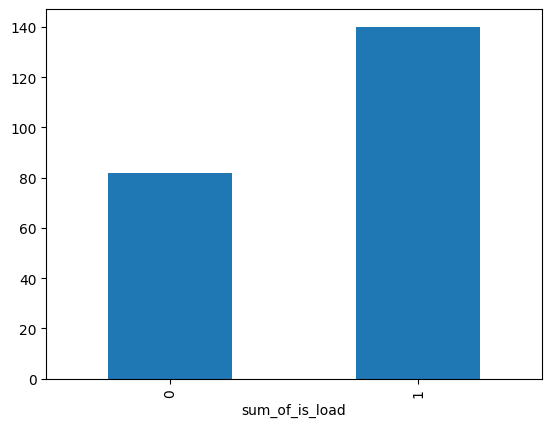

In [13]:
train_data.groupby(['sum_of_is_load'])['target'].mean().plot(kind='bar')
plt.ylabel= ('target mean')
plt.show()

In [ ]:
#X[X['distance'].isna()]['snd_st_id']

#X['distance'] = np.concatenate(knn.fit_transform(X[['distance']])).tolist()
#test_data.isna().sum()

In [ ]:
X.isna().sum()

In [ ]:
train_data.groupby(['group'])['target'].mean()

In [ ]:
#train_data.freight.value_counts()

In [ ]:
#X = train_data.drop(['target','prev_date_arrival','prev_date_depart','rod','date_depart','prev_freight','freight'],axis=1)
#y = train_data['target']

In [15]:
X_train,X_test,y_train,y_test = train_test_split(X,y, train_size = 0.3, test_size = 0.05, shuffle=True, random_state = 42)

In [ ]:
X_train.T

In [16]:
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.preprocessing import OrdinalEncoder


for_distance = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors = 5)),
    ('scaler', MinMaxScaler())
])

# for_prev_fr_group = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('onehotencoder', OneHotEncoder(handle_unknown='ignore'))
# ])

for_weekday = Pipeline(steps=[
    ('onehotencoder', OrdinalEncoder()),
    ('minmax', MinMaxScaler()) 
])
for_common_ch = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehotencoder', OneHotEncoder(handle_unknown='ignore'))])

tmp_groups = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehotencoder', OneHotEncoder(handle_unknown='ignore'))
])

CT = ColumnTransformer([        
        ('distance', for_distance, ['prev_distance','distance']),
        ('vidsobst', OrdinalEncoder(), ['vidsobst']),
        #('group', for_prev_fr_group, ['prev_fr_group','fr_group']),
        ('common_ch', for_common_ch, ['common_ch']),
        ('groups', tmp_groups, ['group', 'prev_group']),    
         ('weekday_name', for_weekday, ['weekday_name'] )
        ],  remainder = MinMaxScaler())


display(CT)
res_ct = CT.fit_transform(X_train)

ColumnTransformer(remainder=MinMaxScaler(),
                  transformers=[('distance',
                                 Pipeline(steps=[('imputer', KNNImputer()),
                                                 ('scaler', MinMaxScaler())]),
                                 ['prev_distance', 'distance']),
                                ('vidsobst', OrdinalEncoder(), ['vidsobst']),
                                ('common_ch',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['common_ch']),
                                ('groups',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['group', 'prev_group']),
                                ('weekday_name',
                                 Pipeline(steps=[('onehotencoder',
                                                  OrdinalEncoder()),
                                                 ('minmax', MinMaxScaler())]),
                                 ['weekday_name'])])

In [27]:
z= pd.DataFrame(res_ct, columns = CT.get_feature_names_out())
z.T

,0,1,2,3,4,5,6,7,8,9,...,468066,468067,468068,468069,468070,468071,468072,468073,468074,468075
distance__prev_distance,0.038559,0.003487,0.018869,0.257127,0.076092,0.011007,0.125248,0.018869,0.242907,0.086005,...,0.386340,0.076024,0.035209,0.000342,0.069255,0.028167,0.128940,0.064333,0.057633,0.088261
distance__distance,0.331766,0.017575,0.000540,0.055577,0.001079,0.033608,0.069837,0.021275,0.124258,0.453172,...,0.399676,0.085639,0.009944,0.144839,0.011100,0.101364,0.144839,0.006783,0.021275,0.107762
vidsobst__vidsobst,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
common_ch__common_ch_9.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
common_ch__common_ch_12.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
common_ch__common_ch_975.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
groups__group_БУМАГА И КАРТОН,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
groups__group_Кокс каменноугольный,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
groups__group_Лесные грузы,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
groups__group_МЕБЕЛЬ,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000


In [28]:
#!pip install catboost
from catboost import CatBoostRegressor

В финальной модели было выбрано 2700 итераций, но по факту у нас была самая лучшая модель на предварительных результатах с 2000 итерациями и 11 глубиной.

In [30]:
#from catboost import CatBoostRegressor
# model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function='RMSE', random_seed=42)
# model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=100)


pipeline = Pipeline([
    ('scaler', CT),
    ('regressor', CatBoostRegressor(iterations=500, 
                                    learning_rate=0.01, 
                                    depth=13, 
                                    loss_function='MAE'))
])

pipeline.fit(X_train,y_train)
pipeline.score(X_train,y_train)
print(pipeline.score(X_train,y_train))
y_pred = pipeline.predict(X_test)
print(mean_absolute_error(y_test, y_pred))
print(pipeline.score(X_test, y_test))

#32.1 У Саши

0:	learn: 54.1234550	total: 277ms	remaining: 2m 18s
1:	learn: 53.9100539	total: 559ms	remaining: 2m 19s
2:	learn: 53.7022013	total: 843ms	remaining: 2m 19s
3:	learn: 53.4868376	total: 1.15s	remaining: 2m 21s
4:	learn: 53.2725864	total: 1.45s	remaining: 2m 23s
5:	learn: 53.0620453	total: 1.73s	remaining: 2m 22s
6:	learn: 52.8671706	total: 2.01s	remaining: 2m 21s
7:	learn: 52.6650177	total: 2.28s	remaining: 2m 20s
8:	learn: 52.4677503	total: 2.57s	remaining: 2m 20s
9:	learn: 52.2753455	total: 2.85s	remaining: 2m 19s
10:	learn: 52.0842457	total: 3.13s	remaining: 2m 18s
11:	learn: 51.8977747	total: 3.41s	remaining: 2m 18s
12:	learn: 51.7069462	total: 3.7s	remaining: 2m 18s
13:	learn: 51.5230398	total: 3.98s	remaining: 2m 17s
14:	learn: 51.3484586	total: 4.22s	remaining: 2m 16s
15:	learn: 51.1747428	total: 4.51s	remaining: 2m 16s
16:	learn: 51.0014558	total: 4.8s	remaining: 2m 16s
17:	learn: 50.8315544	total: 5.08s	remaining: 2m 16s
18:	learn: 50.6632673	total: 5.37s	remaining: 2m 15s
19:	l

156:	learn: 40.2610731	total: 43.8s	remaining: 1m 35s
157:	learn: 40.2359987	total: 44.1s	remaining: 1m 35s
158:	learn: 40.2079514	total: 44.4s	remaining: 1m 35s
159:	learn: 40.1813192	total: 44.7s	remaining: 1m 34s
160:	learn: 40.1559769	total: 45s	remaining: 1m 34s
161:	learn: 40.1317315	total: 45.3s	remaining: 1m 34s
162:	learn: 40.1043474	total: 45.6s	remaining: 1m 34s
163:	learn: 40.0811434	total: 45.8s	remaining: 1m 33s
164:	learn: 40.0565411	total: 46.1s	remaining: 1m 33s
165:	learn: 40.0265206	total: 46.4s	remaining: 1m 33s
166:	learn: 40.0008225	total: 46.7s	remaining: 1m 33s
167:	learn: 39.9722364	total: 47s	remaining: 1m 32s
168:	learn: 39.9523111	total: 47.3s	remaining: 1m 32s
169:	learn: 39.9269428	total: 47.5s	remaining: 1m 32s
170:	learn: 39.9057646	total: 47.8s	remaining: 1m 32s
171:	learn: 39.8801213	total: 48.1s	remaining: 1m 31s
172:	learn: 39.8549026	total: 48.4s	remaining: 1m 31s
173:	learn: 39.8350270	total: 48.7s	remaining: 1m 31s
174:	learn: 39.8130667	total: 49

309:	learn: 37.6823619	total: 1m 26s	remaining: 53.3s
310:	learn: 37.6700334	total: 1m 27s	remaining: 53s
311:	learn: 37.6532902	total: 1m 27s	remaining: 52.7s
312:	learn: 37.6392397	total: 1m 27s	remaining: 52.4s
313:	learn: 37.6267497	total: 1m 28s	remaining: 52.2s
314:	learn: 37.6163929	total: 1m 28s	remaining: 51.9s
315:	learn: 37.6074024	total: 1m 28s	remaining: 51.6s
316:	learn: 37.5980034	total: 1m 28s	remaining: 51.3s
317:	learn: 37.5883042	total: 1m 29s	remaining: 51.1s
318:	learn: 37.5788956	total: 1m 29s	remaining: 50.8s
319:	learn: 37.5722640	total: 1m 29s	remaining: 50.5s
320:	learn: 37.5610267	total: 1m 30s	remaining: 50.2s
321:	learn: 37.5428723	total: 1m 30s	remaining: 50s
322:	learn: 37.5334596	total: 1m 30s	remaining: 49.7s
323:	learn: 37.5269892	total: 1m 30s	remaining: 49.4s
324:	learn: 37.5123023	total: 1m 31s	remaining: 49.1s
325:	learn: 37.4940344	total: 1m 31s	remaining: 48.9s
326:	learn: 37.4787929	total: 1m 31s	remaining: 48.6s
327:	learn: 37.4690232	total: 1m

463:	learn: 36.2208990	total: 2m 11s	remaining: 10.2s
464:	learn: 36.2115963	total: 2m 11s	remaining: 9.93s
465:	learn: 36.2068581	total: 2m 12s	remaining: 9.64s
466:	learn: 36.2017981	total: 2m 12s	remaining: 9.36s
467:	learn: 36.1960674	total: 2m 12s	remaining: 9.08s
468:	learn: 36.1890159	total: 2m 13s	remaining: 8.79s
469:	learn: 36.1829911	total: 2m 13s	remaining: 8.51s
470:	learn: 36.1768834	total: 2m 13s	remaining: 8.22s
471:	learn: 36.1712252	total: 2m 13s	remaining: 7.94s
472:	learn: 36.1636084	total: 2m 14s	remaining: 7.66s
473:	learn: 36.1569923	total: 2m 14s	remaining: 7.38s
474:	learn: 36.1507223	total: 2m 14s	remaining: 7.09s
475:	learn: 36.1429121	total: 2m 15s	remaining: 6.81s
476:	learn: 36.1374408	total: 2m 15s	remaining: 6.52s
477:	learn: 36.1269519	total: 2m 15s	remaining: 6.24s
478:	learn: 36.1211107	total: 2m 15s	remaining: 5.96s
479:	learn: 36.1164262	total: 2m 16s	remaining: 5.67s
480:	learn: 36.1119626	total: 2m 16s	remaining: 5.39s
481:	learn: 36.1075873	total

In [31]:
test_data = pd.read_parquet('test.parquet')
test_data = __transfomate(test_data).drop(['prev_date_arrival','prev_date_depart','rod','prev_freight','freight', 'fr_group', 'prev_fr_group'], axis = 1)
test_data

,wagnum,prev_fr_id,prev_is_load,prev_snd_org_id,prev_rsv_org_id,prev_distance,snd_st_id,rsv_st_id,fr_id,is_load,...,vidsobst,snd_org_id,rsv_org_id,distance,part_of_the_day,sum_of_is_load,quarter,weekday_name,group,prev_group
0,11,3399285,1.0,4272291,5236848,656.000000,1453117,9430763,1399685,0,...,Собственные,2327070,6683733,3723.0,0,0,4,Saturday,Нефтяные грузы,Лесные грузы
1,11,3642924,1.0,6683733,2661726,4004.000000,7794458,8264989,1399685,0,...,Собственные,2327070,3601745,302.0,2,0,4,Thursday,Нефтяные грузы,МЕБЕЛЬ
2,11,8936509,1.0,3601745,4540052,267.000000,1597089,95805,1399685,0,...,Собственные,2327070,699208,1968.0,3,0,4,Thursday,Нефтяные грузы,Хлебные грузы
3,276,3821223,1.0,4597939,4097118,1112.000000,4224949,5821322,1399685,0,...,Принятые в аренду,2327070,4597939,1112.0,0,0,4,Monday,Нефтяные грузы,ОРЕХИ
4,276,8631635,1.0,5042377,8445007,2198.000000,4166442,6796566,1399685,0,...,Принятые в аренду,8445007,9932239,584.0,3,0,4,Saturday,Нефтяные грузы,Остальные грузы
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221081,9999730,7003547,1.0,4266126,7290981,1844.000000,9967639,1184093,4010990,1,...,Собственные,7290981,8035951,2679.0,2,1,4,Thursday,МЕБЕЛЬ,Лесные грузы
221082,9999859,292757,1.0,4533990,9321847,204.000000,4985724,2492408,8674472,1,...,Собственные,9321847,4272291,3584.0,1,1,4,Monday,МЕБЕЛЬ,МЕБЕЛЬ
221083,9999859,7399715,1.0,4272291,9162812,1315.000000,5029245,4856554,1399685,0,...,Собственные,2327070,4570269,152.0,2,0,4,Friday,Нефтяные грузы,Лесные грузы
221084,9999859,1399685,0.0,2327070,4533990,4480.000000,3609555,8645707,7486030,1,...,Собственные,4533990,987513,5906.0,0,0,4,Saturday,МЕБЕЛЬ,Нефтяные грузы


Это предикт для проверки качества

In [37]:
y_predic = pipeline.predict(X_test)
y_predic

array([ 90.84722895,  29.16045088,  88.0975461 , ...,  81.49021938,
        32.44128206, 169.79343015])

Это финальный предикт для выгрузки

In [38]:
# 0.5184023923958212
# 32.22051417112773
# 0.4493562754928654
# train=0.3, test = 0.05
y_predicted = pipeline.predict(test_data)
y_predicted

array([101.5890324 ,  75.75276485, 108.70690677, ...,  32.49298926,
        73.5568712 , 104.06343468])

Проверка на метрике от организаторов

In [39]:
def calc_metric(x, y):

    return (np.abs(x - y) < 12).sum() / len(x)

calc_metric(y_test, y_predic)

0.3901272864778947

In [40]:
pipeline['regressor'].feature_importances_

array([7.83660535e+00, 9.52069300e+00, 0.00000000e+00, 1.77424615e-01,
       0.00000000e+00, 2.38534540e-01, 2.96900487e-01, 0.00000000e+00,
       9.10736719e-01, 4.69097749e+00, 0.00000000e+00, 1.08605990e+00,
       0.00000000e+00, 2.82664307e+00, 2.49982044e-02, 5.86422633e-03,
       9.67425922e-02, 0.00000000e+00, 2.08506207e-02, 0.00000000e+00,
       3.59006051e-02, 0.00000000e+00, 2.35315228e+00, 1.70126435e+00,
       0.00000000e+00, 5.58293130e-01, 1.30945783e+00, 1.32462973e-01,
       3.66470149e-02, 0.00000000e+00, 0.00000000e+00, 1.93765549e-01,
       1.72693910e+00, 0.00000000e+00, 4.77586762e+00, 1.14776466e+00,
       2.82594135e+00, 1.19695231e+01, 1.23566418e+01, 2.77373850e+00,
       6.98122732e+00, 3.17491724e-01, 2.84414898e+00, 2.83907499e+00,
       8.05717718e-01, 8.22699332e+00, 6.35495534e+00])

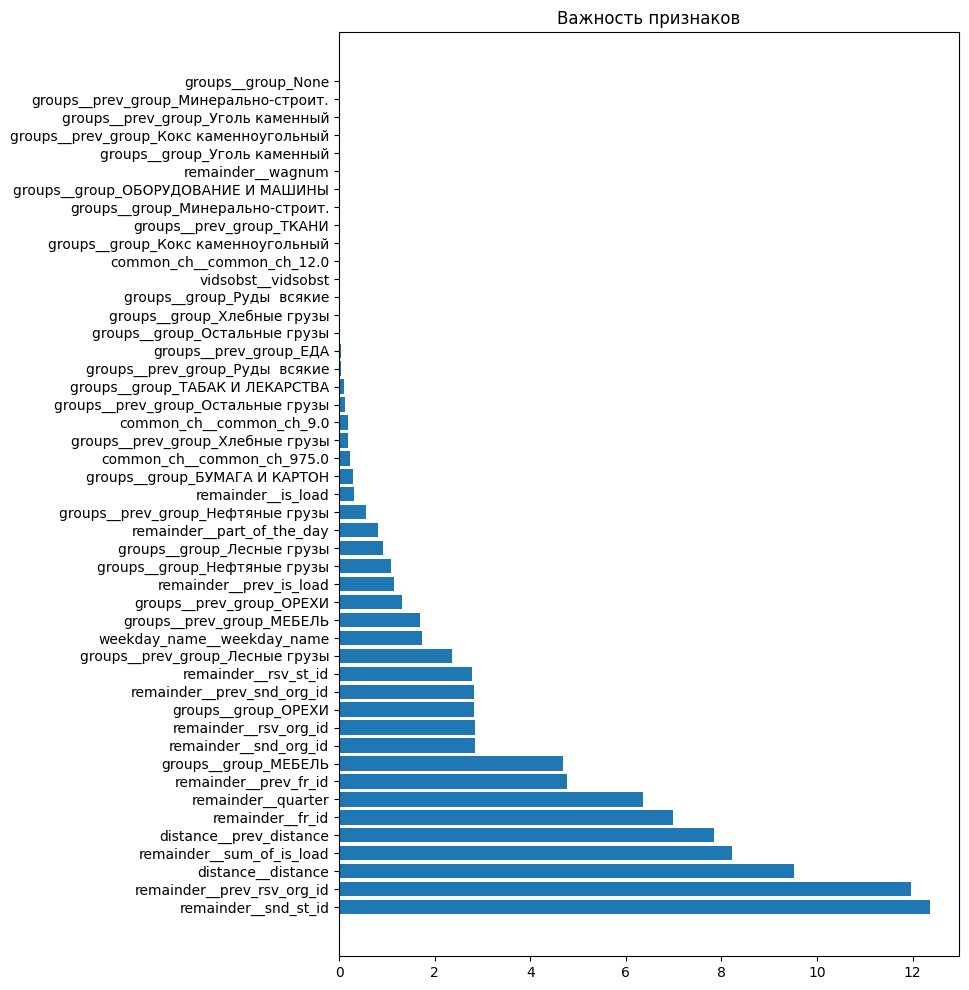

In [43]:
importance = np.sort(pipeline['regressor'].feature_importances_)
importance_name = np.argsort(pipeline['regressor'].feature_importances_)
feature_names = z.columns

plt.figure(figsize=(8, 12))
plt.barh(width=importance, y = feature_names[importance_name] )
ax = plt.gca()
ax.invert_yaxis()
plt.title("Важность признаков")
plt.show()

In [44]:
y_sample_submit = pd.read_csv('test_submit_example.csv')
y_sample_submit['target'] = y_predicted
y_sample_submit.to_csv('submit_final.csv', index=False)

In [45]:
y_sample_submit

,target
0,101.589032
1,75.752765
2,108.706907
3,47.881961
4,95.995713
...,...
221081,214.277416
221082,72.008214
221083,32.492989
221084,73.556871
